In [1]:
import numpy as np
import pandas as pd
import os
import io
import seaborn as sns
import requests
import json

import matplotlib.pyplot as plt
import pymc3 as pm

import scipy
import scipy.stats as stats
import scipy.optimize as opt
#import statsmodels.api as sm

from pymc3 import Model, Normal, Slice
from pymc3 import sample
from pymc3 import traceplot
from pymc3.distributions import Interpolated, Mixture
import theano.tensor as tt 
from pymc3.distributions.distribution import Continuous, draw_values, generate_samples

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', 500)
%matplotlib inline 

In [2]:
data = pd.read_csv("data/combined_seasons.csv")

In [3]:
data.head()

,Unnamed: 0,Assist1,Assist1_ID,Assist2,Assist2_ID,Assists2_ID,Away,Away_Score,EmptyNet,Event,EventID,Event_Description,Event_Team,Event_Type_ID,Final_Away_Score,Final_Home_Score,GameDate,GameID,GameState,GameType,Goalie,Goalie_ID,Home,Home_Score,Period,Period_Type,Player_1_ID,Player_1_Name,Player_2_ID,Player_2_Name,Scorer,Scorer_ID,Shooter,Shooter_ID,ShotType,Time_Remaining,Time_in_Period,Venue,x,y,Side,Season,y_stdz,x_stdz,y_normal,x_normal,Event_Team_Adj,y_same,x_same,zone_x,zone_y,shot_zone,Opposition Team,Shifted_Event_Type_ID,Shifted_shot_zone,Shifted_Time_Remaining,Event_Time_Difference,Shot_Context
0,0,None,None,None,NaN,None,Vancouver Canucks,0,None,Game Scheduled,1,Game Scheduled,None,GAME_SCHEDULED,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,NaN,NaN,NaN,NaN,Non-Shot Event
1,1,None,None,None,NaN,None,Vancouver Canucks,0,None,Period Ready,54,Period Ready,None,PERIOD_READY,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,GAME_SCHEDULED,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
2,2,None,None,None,NaN,None,Vancouver Canucks,0,None,Period Start,2,Period Start,None,PERIOD_START,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,None,None,None,None,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,NaN,NaN,NaN,2017-2018,NaN,NaN,NaN,NaN,None,NaN,NaN,Other,NaN,Other,Los Angeles Kings,PERIOD_READY,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
3,3,None,None,None,NaN,None,Vancouver Canucks,0,None,Faceoff,3,Markus Granlund faceoff won against Adrian Kempe,Vancouver Canucks,FACEOFF,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,8476440,Markus Granlund,8477960,Adrian Kempe,None,None,None,None,None,1900-01-01 00:20:00,00:00,STAPLES Center,0.0,0.0,left,2017-2018,0.0,0.0,-0.0,-0.0,Vancouver Canucks,-0.0,-0.0,Other,Center,Other,Los Angeles Kings,PERIOD_START,Other,1900-01-01 00:20:00,0.0,Non-Shot Event
4,4,None,None,None,NaN,None,Vancouver Canucks,0,None,Penalty,57,Adrian Kempe Hooking against Philip Holm,Los Angeles Kings,PENALTY,4,3,2017-09-16,2017010001,6,PR,None,None,Los Angeles Kings,0,1,REGULAR,8477960,Adrian Kempe,8480163,Philip Holm,None,None,None,None,Hooking,1900-01-01 00:19:41,00:19,STAPLES Center,11.0,36.0,right,2017-2018,36.0,11.0,-36.0,-11.0,Los Angeles Kings,36.0,11.0,Other,Right Board,Other,Vancouver Canucks,FACEOFF,Other,1900-01-01 00:20:00,19.0,Non-Shot Event


In [4]:
hurricanes = data[(data['GameType'] == 'R') & (data['Event_Type_ID'] == 'GOAL') & (data['EmptyNet'] != 'True') & (data['Period'] != 4) & (data['Period'] != 5) & ((data['Away'] == 'Carolina Hurricanes') | (data['Home'] == 'Carolina Hurricanes'))].reset_index()

In [5]:
hurricanes['Period'].unique()

array([1, 2, 3])

In [6]:
canes_games = hurricanes[['Event_Type_ID', 'Home', 'Away', 'Period', 'GameID', 'Event_Team', 'GameDate', 'Season','Final_Away_Score', 'Final_Home_Score']]

In [7]:
canes_games['Opponent'] = canes_games['Event_Team'].apply(lambda x: x if x == 'Carolina Hurricanes' else 'Opponent')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
grouped = canes_games[['GameID', 'Opponent', 'Period']].groupby(['GameID', 'Opponent']).count().reset_index()
grouped = grouped.groupby(['GameID', 'Opponent'])['Period'].aggregate('mean').unstack().reset_index().fillna(0)
game_info = canes_games[['GameID', 'Final_Away_Score', 'Final_Home_Score', 'Home', 'Away', 'GameDate', 'Season']].drop_duplicates()
game_data = game_info.merge(grouped, on='GameID', how='inner')
game_data['GoalDiff'] = game_data['Carolina Hurricanes'] - game_data['Opponent']

In [13]:
df_2018 = game_data[game_data['Season'] == '2017-2018'].reset_index()
df_2019 = game_data[game_data['Season'] == '2018-2019'].reset_index()

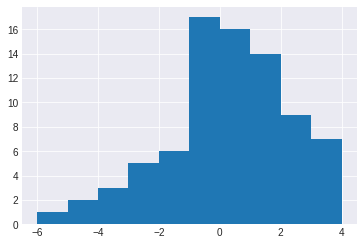

In [14]:
df_2018['GoalDiff'].hist()

In [25]:
with pm.Model() as model:
    
    #Pooled Parameters
    mu_normal = pm.Uniform('mu_normal', lower=-10.0, upper=10.0)
    sd_normal = pm.Uniform('sd_normal', lower=0.5, upper=6)
    #nu_t = pm.Uniform('nu_normal', lower=1, upper=100)
    
    likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=df_2018['GoalDiff'].values)
    #y_est = pm.Normal('y_est', mu=mu_normal, sd=sd_normal)
    
    trace = pm.sample(50000, cores=-1, tune=2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [00:50<00:00, 1042.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f383c95f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4f383c9b70>]], dtype=object)

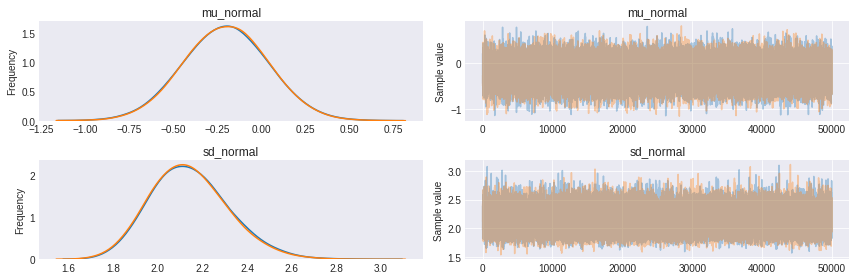

In [26]:
pm.traceplot(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f384aa860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f4f38334588>], dtype=object)

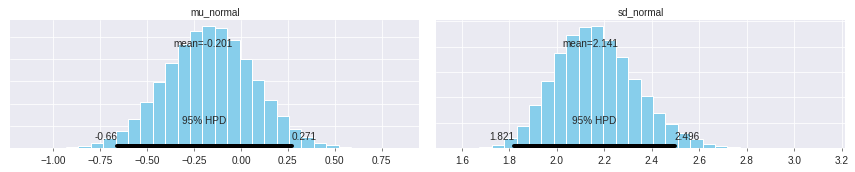

In [27]:
pm.plot_posterior(trace)

In [42]:
import pickle

with open('20172018_trace', 'wb') as handle:
    pickle.dump(trace, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [28]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)
    
    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param, x, y)

In [29]:
def prob_persona_faster(persona, personb):
    return np.float(sum(np.array(persona) - np.array(personb) > 0))/len(personb)

In [31]:
len(trace.get_values('mu_normal'))

100000

In [32]:
probabilities = []
for i in range(0, len(df_2019)):
    observed = df_2019[0:i+1]['GoalDiff'].values
    cont = True
    while cont == True:
        try:
            with pm.Model() as model:
                #Pooled Parameters
                mu_normal = from_posterior('mu_normal', trace['mu_normal'])
                sd_normal = from_posterior('sd_normal', trace['sd_normal'])

                likelihood = pm.Normal('likelihood', mu=mu_normal, sd=sd_normal, observed=observed)

                trace2 = pm.sample(50000, cores=-1, tune=2500)
                
            probabilities.append(prob_persona_faster(trace2.get_values('mu_normal'), trace.get_values('mu_normal')))
            print(probabilities)
            cont = False
        except:
            pass

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:05<00:00, 805.82it/s]
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 258 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


[0.50301]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:30<00:00, 580.72it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.614242685865, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50301, 0.53354]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:31<00:00, 576.80it/s]


[0.50301, 0.53354, 0.56934]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:26<00:00, 609.47it/s]
The acceptance probability does not match the target. It is 0.891449432966, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50301, 0.53354, 0.56934, 0.60035]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:33<00:00, 564.41it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:19<00:00, 659.85it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/52500 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:09<00:00, 758.23it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:08<00:00, 767.26it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:15<00:00, 699.45it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 820.78it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 834.42it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 843.52it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:07<00:00, 772.97it/s]
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 842.73it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 819.38it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 831.63it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 829.16it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 818.63it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/52500 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:01<00:00, 848.40it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 838.64it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 830.83it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 814.87it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 825.78it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 811.38it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 822.99it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 835.90it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 842.25it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/52500 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:05<00:00, 795.97it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 838.00it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/52500 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:07<00:00, 776.29it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 844.10it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:05<00:00, 801.75it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:05<00:00, 796.13it/s]
The acceptance probability does not match the target. It is 0.713795690196, but should be close to 0.8. Try to increase the number of tuning steps.


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:05<00:00, 805.06it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:02<00:00, 833.58it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 816.08it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
  0%|          | 0/52500 [00:00<?, ?it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 826.94it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271, 0.43403]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:03<00:00, 826.50it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271, 0.43403, 0.46233]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 812.87it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271, 0.43403, 0.46233, 0.48589]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 815.58it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271, 0.43403, 0.46233, 0.48589, 0.50306]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd_normal, mu_normal]
100%|██████████| 52500/52500 [01:04<00:00, 815.76it/s]


[0.50301, 0.53354, 0.56934, 0.60035, 0.60159, 0.58913, 0.58098, 0.55259, 0.56777, 0.5742, 0.56199, 0.54905, 0.55437, 0.51083, 0.48468, 0.50359, 0.50489, 0.51031, 0.46972, 0.48659, 0.50145, 0.53486, 0.49832, 0.50977, 0.51321, 0.50367, 0.45415, 0.48139, 0.44593, 0.43574, 0.44129, 0.48137, 0.45873, 0.42378, 0.45098, 0.44271, 0.43403, 0.46233, 0.48589, 0.50306, 0.51586]


In [33]:
len(probabilities)

41

In [34]:
df_2019.tail()

,index,GameID,Final_Away_Score,Final_Home_Score,Home,Away,GameDate,Season,Carolina Hurricanes,Opponent,GoalDiff
36,116,2018020583,0,2,New Jersey Devils,Carolina Hurricanes,2018-12-29,2018-2019,0.0,1.0,-1.0
37,117,2018020602,1,3,Carolina Hurricanes,Philadelphia Flyers,2018-12-31,2018-2019,3.0,1.0,2.0
38,118,2018020625,5,3,Philadelphia Flyers,Carolina Hurricanes,2019-01-03,2018-2019,5.0,3.0,2.0
39,119,2018020631,2,4,Carolina Hurricanes,Columbus Blue Jackets,2019-01-04,2018-2019,3.0,2.0,1.0
40,120,2018020647,5,4,Ottawa Senators,Carolina Hurricanes,2019-01-06,2018-2019,5.0,4.0,1.0


In [35]:
df_2019 = df_2019.reset_index()

In [36]:
df_2019['Probability'] = probabilities

In [38]:
#Format Opponent Name/Dates
df_2019['OpposingTeam'] = df_2019.apply(lambda row: row['Home'] if row['Home'] != 'Carolina Hurricanes' else row['Away'], axis=1)
df_2019['Opponent2'] =  pd.to_datetime(df_2019['GameDate']).dt.strftime("%b %d") + " \n " + df_2019['OpposingTeam']

[ 0.       0.50301]
[ 1.       0.53354]
[ 2.       0.56934]
[ 3.       0.60035]
[ 4.       0.60159]
[ 5.       0.58913]
[ 6.       0.58098]
[ 7.       0.55259]
[ 8.       0.56777]
[ 9.      0.5742]
[ 10.        0.56199]
[ 11.        0.54905]
[ 12.        0.55437]
[ 13.        0.51083]
[ 14.        0.48468]
[ 15.        0.50359]
[ 16.        0.50489]
[ 17.        0.51031]
[ 18.        0.46972]
[ 19.        0.48659]
[ 20.        0.50145]
[ 21.        0.53486]
[ 22.        0.49832]
[ 23.        0.50977]
[ 24.        0.51321]
[ 25.        0.50367]
[ 26.        0.45415]
[ 27.        0.48139]
[ 28.        0.44593]
[ 29.        0.43574]
[ 30.        0.44129]
[ 31.        0.48137]
[ 32.        0.45873]
[ 33.        0.42378]
[ 34.        0.45098]
[ 35.        0.44271]
[ 36.        0.43403]
[ 37.        0.46233]
[ 38.        0.48589]
[ 39.        0.50306]
[ 40.        0.51586]


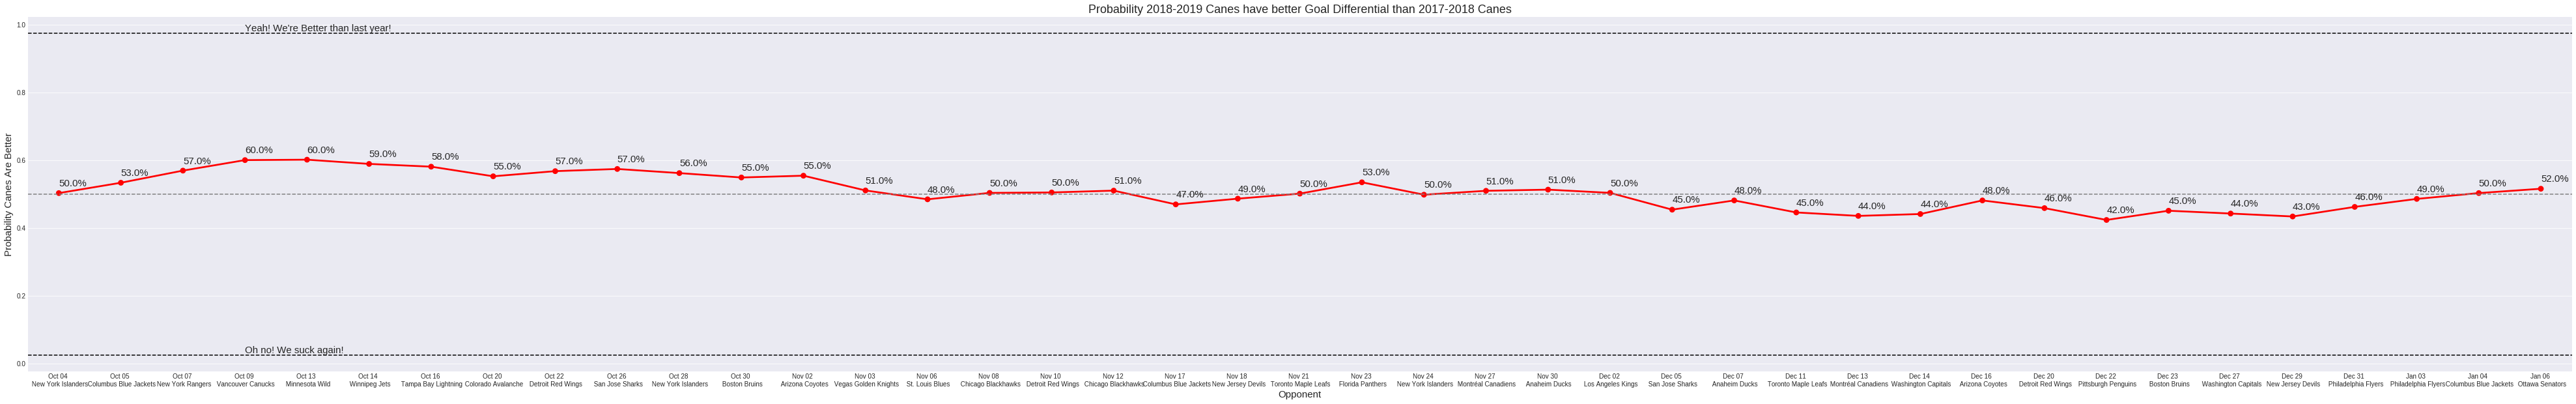

In [39]:
fig, ax = plt.subplots(figsize=(70, 10))
ax.set_title('Probability 2018-2019 Canes have better Goal Differential than 2017-2018 Canes', fontsize=18)
p1 = sns.pointplot(x=df_2019['Opponent2'], y=df_2019['Probability'], color='red')
plt.axhline(.975, color='black', ls='--', label= "Yeah! We're Better than Last Year!")
plt.axhline(.025, color='black', ls='--', label= "Nope We Suck")
plt.axhline(.50, color='grey', ls='--')
p1.set_ylabel('Probability Canes Are Better', fontsize=15)
p1.set_xlabel('Opponent', fontsize=15)
for c in ax.collections:
    for of in c.get_offsets():
        print(of)
        of2 = [of[0], of[1]+0.02]
        ax.annotate('%r' % round(of[1]*100, 0) + "%", of2, size=15)
ax.annotate("Yeah! We're Better than last year!", [3, .98], size=15)
ax.annotate("Oh no! We suck again!", [3, .03], size=15)
plt.show()

In [40]:
df_2019['Probabilities'] = probabilities

In [41]:
df_2019.to_csv("canes.csv")